<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/2f_speech_cnn2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de comandos de voz con CNN 2D

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En esta libreta veremos un ejemplo de clasificación de audio empleando espectrogramas y redes convolucionales 2D.

[Speech Commands](https://arxiv.org/abs/1804.03209) es un conjunto de comandos de voz (palabras) con más de 100k ejemplos. Cada audio dura alrededor de 1 segundo y tienen un solo canal de voz con una frecuencia de muestreo de 16000hz.

<img src="https://d3i71xaburhd42.cloudfront.net/da6e404d8911b0e5785019a79dc8607e0b313dc4/7-Figure1-1.png"  style="width: 200px;" />

## 1. Preparación

In [1]:
# Colab
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

### 1.1. Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

### 1.2. Auxiliares

In [3]:
# directorio de datos
DATA_DIR = '../datos/speech_commands'

# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# parámetros FFT
N_FFT = 400
HOP_LENGTH = N_FFT // 2

# SpeechCommands classes
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn', 
    'left', 'marvin', 'nine', 'no', 'off', 
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)
NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2. Datos

### 2.1. Descarga

In [4]:
! mkdir -p {DATA_DIR}

In [5]:
ds = SPEECHCOMMANDS(DATA_DIR, download=True)

In [6]:
len(ds)

105829

In [7]:
! ls -R {DATA_DIR} | head -55

../datos/speech_commands:
SpeechCommands
speech_commands_v0.02.tar.gz

../datos/speech_commands/SpeechCommands:
speech_commands_v0.02

../datos/speech_commands/SpeechCommands/speech_commands_v0.02:
LICENSE
README.md
_background_noise_
backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
testing_list.txt
three
tree
two
up
validation_list.txt
visual
wow
yes
zero

../datos/speech_commands/SpeechCommands/speech_commands_v0.02/_background_noise_:
README.md
doing_the_dishes.wav
dude_miaowing.wav
exercise_bike.wav
pink_noise.wav
ls: write error: Broken pipe


### 2.2. Conjunto de datos

In [8]:
def identity(x):
    return x


def label2index(label):
    return CLASS_IDX[label]


class SPEECHCOMMANDS2(SPEECHCOMMANDS):

    def __init__(self, root, download=False, subset=None,
                 waveform_tsfm=identity, label_tsfm=identity):
        super().__init__(root=root, download=download, subset=subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm

    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
        x = self.waveform_tsfm(waveform)
        y = self.label_tsfm(label)
        return x, y, label, sample_rate


class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=SECS, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate
    
    def forward(self, waveform):
        samples = waveform.shape[1]

        # rellenamos con zeros
        if samples < self.samples:
            difference = self.samples - samples
            padding = torch.zeros(1, difference)
            waveform = torch.cat([waveform, padding], 1)

        # recortamos
        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            waveform = waveform.narrow(1, start, self.samples)
        
        return waveform

In [9]:
# creamos un Dataset
ds = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
)

# creamos un DataLoader
dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
)

# desplegamos un lote de imágenes
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


### 2.3. Cargadores de datos

In [10]:
def build_dl(subset=None, spectrogram='spec', shuffle=False):

    waveform_tsfm = [
        WaveformPadTruncate()
    ]

    if spectrogram == 'spec':
        waveform_tsfm.extend([
            T.Spectrogram(n_fft=N_FFT),
            T.AmplitudeToDB(),
        ])
    elif spectrogram == 'mel':
        waveform_tsfm.extend([
            T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT),
            T.AmplitudeToDB(),
        ])
    elif spectrogram == 'mfcc':
        waveform_tsfm.extend([
            T.MFCC(sample_rate=SAMPLE_RATE),
        ])
    else:
        raise NotImplementedError(
            f'Espectrograma no implementado: {spectrogram}')

    waveform_tsfm = nn.Sequential(*waveform_tsfm)
    
    
        # creamos un Dataset
    ds = SPEECHCOMMANDS2(
        # directorio de datos
        root=DATA_DIR,
        # subconjunto
        subset=subset,
        # transformación de la forma de onda
        waveform_tsfm=waveform_tsfm,
        # transformación de etiqueta
        label_tsfm=label2index,
    )

    # creamos un DataLoader
    dl = DataLoader(
        # conjunto
        ds,
        # tamaño del lote
        batch_size=BATCH_SIZE,
        # barajear
        shuffle=shuffle,
        # procesos paralelos
        num_workers=2
    )
    return dl

### 2.4. Espectrogramas

x shape=torch.Size([32, 1, 201, 81]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


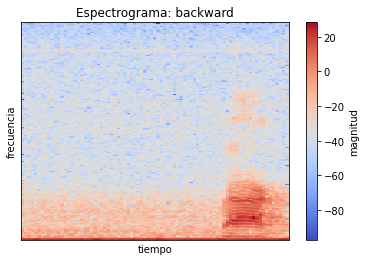

In [11]:
dl = build_dl(spectrogram='spec')

# inspeccionemos el lote
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
spec = x[0].squeeze().numpy()
label = labels[0]

librosa.display.specshow(spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.title(f'Espectrograma: {label}')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

### 2.5. Espectrogramas Log-Mel

/home/richardt/.miniconda3/envs/iap/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


x shape=torch.Size([32, 1, 128, 81]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


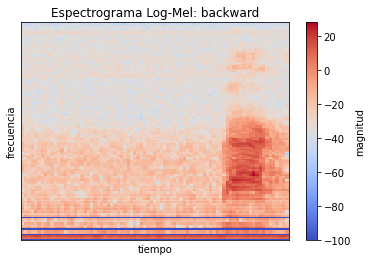

In [12]:
dl = build_dl(spectrogram='mel')

# inspeccionemos el lote
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
spec = x[0].squeeze().numpy()
label = labels[0]

librosa.display.specshow(spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.title(f'Espectrograma Log-Mel: {label}')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

### 2.6. Espectrogramas MFCCs

x shape=torch.Size([32, 1, 40, 81]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


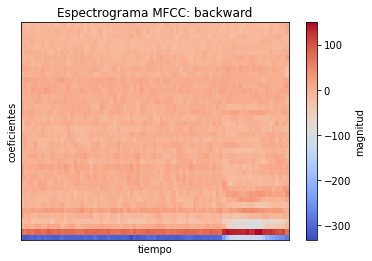

In [13]:
dl = build_dl(spectrogram='mfcc')

# inspeccionemos el lote
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
spec = x[0].squeeze().numpy()
label = labels[0]

librosa.display.specshow(spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.title(f'Espectrograma MFCC: {label}')
plt.xlabel('tiempo')
plt.ylabel('coeficientes')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

## 3. Ciclo de entrenamiento

In [14]:
def train_epoch(dl, model, opt, device):

    # por cada lote
    for x, y_true, *_ in dl:

        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)

        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true, *_ in take(dl, num_batches):

            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # modelo en modo de entrenamiento
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # modelo en modo de evaluación
        model.eval()
        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, device, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

## 4. Arquitectura

In [15]:
class CNN(nn.Module):

    def __init__(self, n_in_channels=1, n_classes=NUM_CLASSES, n_channel=32):
        super().__init__()

        self.cnn = nn.Sequential(

            # bloque conv 1
            nn.Conv2d(in_channels=n_in_channels, 
                      out_channels=n_channel,
                      kernel_size=3),
            nn.BatchNorm2d(n_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # bloque conv 2
            nn.Conv2d(in_channels=n_channel, 
                      out_channels=n_channel, 
                      kernel_size=3),
            nn.BatchNorm2d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # bloque conv 3
            nn.Conv2d(in_channels=n_channel,
                      out_channels=2*n_channel,
                      kernel_size=3),
            nn.BatchNorm2d(num_features=2*n_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # bloque conv 4
            nn.Conv2d(in_channels=2*n_channel,
                      out_channels=2*n_channel,
                      kernel_size=3),
            nn.BatchNorm2d(num_features=2*n_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(2*n_channel, n_classes)


    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x
    
def build_cnn():
    return CNN()

cnn = build_cnn()
cnn

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [16]:
x = torch.zeros(1, 1, 201, 81)
y = cnn(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 201, 81]) => torch.Size([1, 35])


In [17]:
summary(cnn, (1, 1, 201, 81), device='cpu', verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─Sequential: 1-1                        [1, 1, 201, 81]           [1, 64, 10, 3]            --
|    └─Conv2d: 2-1                       [1, 1, 201, 81]           [1, 32, 199, 79]          320
|    └─BatchNorm2d: 2-2                  [1, 32, 199, 79]          [1, 32, 199, 79]          64
|    └─ReLU: 2-3                         [1, 32, 199, 79]          [1, 32, 199, 79]          --
|    └─MaxPool2d: 2-4                    [1, 32, 199, 79]          [1, 32, 99, 39]           --
|    └─Conv2d: 2-5                       [1, 32, 99, 39]           [1, 32, 97, 37]           9,248
|    └─BatchNorm2d: 2-6                  [1, 32, 97, 37]           [1, 32, 97, 37]           64
|    └─ReLU: 2-7                         [1, 32, 97, 37]           [1, 32, 97, 37]           --
|    └─MaxPool2d: 2-8                    [1, 32, 97, 37]           [1, 32, 48, 18]           --
|    └─Conv2d: 2-9             

## 5. Entrenamiento

In [18]:
def train_model(spectrogram, build_model, lr=1e-4, epochs=5):
    set_seed()
    trn_dl = build_dl('training', spectrogram, shuffle=True)
    val_dl = build_dl('validation', spectrogram, shuffle=False)
    model = build_model()
    loss_hist, acc_hist = train(
        model, trn_dl, val_dl, lr=lr, epochs=epochs)

In [19]:
train_model(spectrogram='spec', build_model=build_cnn)

  0%|          | 0/5 [00:00<?, ?it/s]

E00 loss=[279.88,277.45] acc=[28.32,29.74]
E01 loss=[227.50,225.39] acc=[43.91,45.46]
E02 loss=[185.44,181.51] acc=[53.40,55.74]
E03 loss=[159.81,155.43] acc=[59.59,61.89]
E04 loss=[146.07,141.80] acc=[62.67,64.85]


## 6. Participación

Adapta una arquitectura del estado del arte y entrena un modelo con algún espectrograma.